# Cicero

Analysing co-accessibility using Cicero.

Tutorial: https://cole-trapnell-lab.github.io/cicero-release/docs_m3

In [1]:
library(cicero)
library(Matrix)
library(ggplot2)
library(scales)
library(rtracklayer)

Loading required package: monocle3

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignette

## Load Data

In [2]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.overlap.smallpeaks.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 803958

In [3]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 68916     5

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
                    cells              
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA

In [4]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 803958      4

chr  bp1       bp2       site_name               
chr1_97145604_97145864   chr1  97145604  97145864 chr1_97145604_97145864  
chr1_7538148_7538363     chr1   7538148   7538363 chr1_7538148_7538363    
chr1_93196678_93196894   chr1  93196678  93196894 chr1_93196678_93196894  
chr1_187577713_187577913 chr1 187577713 187577913 chr1_187577713_187577913
chr1_53278065_53278265   chr1  53278065  53278265 chr1_53278065_53278265  
chr1_177176832_177177032 chr1 177176832 177177032 chr1_177176832_177177032

In [5]:
# sort by coordinate (just to be safe)
pmat = pmat[,order(regions$chr, regions$bp1)]
regions = regions[order(regions$chr, regions$bp1), ]

In [6]:
head(regions)

chr  bp1   bp2   site_name       
chr1_10505_10717 chr1 10505 10717 chr1_10505_10717
chr1_42145_42371 chr1 42145 42371 chr1_42145_42371
chr1_46217_46443 chr1 46217 46443 chr1_46217_46443
chr1_48625_48825 chr1 48625 48825 chr1_48625_48825
chr1_51436_51661 chr1 51436 51661 chr1_51436_51661
chr1_51691_51930 chr1 51691 51930 chr1_51691_51930

## Sanity Check

To see if metaData, matrix and regions are well-aligned

In [7]:
pmatRowSums = Matrix::rowSums(pmat)

In [8]:
# region_gr = read.table("../../../resources/GSE36570/DBRs.hg38.bed")
region_gr = read.table("../20200307_fine_clustering/beds/20200330_gridmap_peakwidthnorm_n20/idx5.bed")
colnames(region_gr) = c("chr", "start", "end")
region_gr = makeGRangesFromDataFrame(region_gr)

In [9]:
tmp_regions = regions[,c("chr", "bp1", "bp2")]
colnames(tmp_regions) = c("chr", "start", "end")
norm_reads_in_region = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(GRanges(tmp_regions), region_gr)))])/pmatRowSums

In [10]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)

[1] 0.1496645

[1] 0.003621002

[1] 0

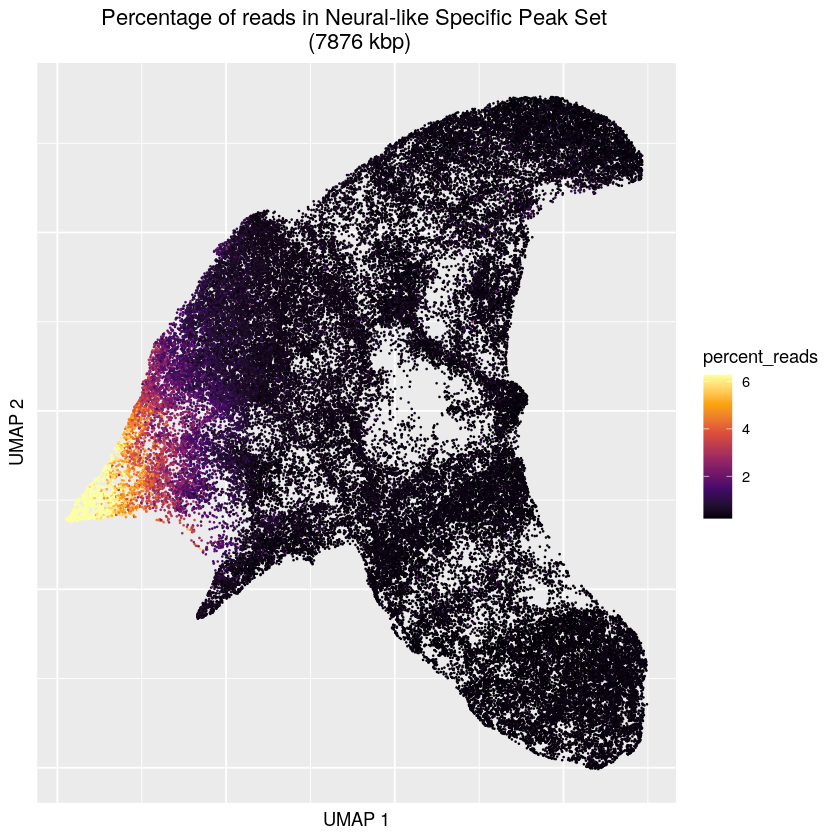

In [11]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(metaData, percent_reads=100*norm_reads_in_region)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap1 , y=umap2, col=percent_reads)) +
ggtitle(sprintf("Percentage of reads in Neural-like Specific Peak Set \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(100*norm_reads_in_region, 0.1), 
                               quantile(100*norm_reads_in_region, 0.99)), 
                      oob=squish, option = "B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

In [12]:
# check if reads at OCT promoter (none in initial version)
sum(pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), GRanges(tmp_regions)))])

[1] 537

## Running Cicero 

In [13]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [23]:
row.names(pmat) <- row.names(metaData)
colnames(pmat) <- row.names(regions)

In [24]:
input_cds <-  new_cell_data_set(t(pmat),  # need to transpose based on tutorial
              cell_metadata = metaData,
              gene_metadata = regions)

Warning message in new_cell_data_set(t(pmat), cell_metadata = metaData, gene_metadata = regions):
"Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions."


In [25]:
input_cds <- monocle3::detect_genes(input_cds)

#Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,] 

In [26]:
umap_df = data.frame(umap_coord1=metaData$umap1, umap_coord2=metaData$umap2)
rownames(umap_df) = rownames(metaData)
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_df, k=200)

Overlap QC metrics:
Cells per bin: 200
Maximum shared cells bin-bin: 179
Mean shared cells bin-bin: 0.577283464189112
Median shared cells bin-bin: 0



In [27]:
cicero_cds

class: cell_data_set 
dim: 803958 3820 
metadata(1): cds_version
assays(1): counts
rownames(803958): chr1_10505_10717 chr1_42145_42371 ...
  chrY_26671002_26671239 chrY_26671289_26671489
rowData names(5): chr bp1 bp2 site_name num_cells_expressed
colnames(3820): agg32428 agg58994 ... agg58487 agg44645
colData names(3): agg_cell Size_Factor num_genes_expressed
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [28]:
hg38.chrom.sizes = read.table("~/genomes/hg38/hg38.chrom.sizes")
# sample_genome <- subset(hg38.chrom.sizes, V1 == "chr2")
# sample_genome$V2[1] <- 10000000

---

**Option 1**: Run the cells below to run with default paramters, which works when density of elements is not high. Works when peaks are merged and of variable size.

In [ ]:
# conns <- run_cicero(cicero_cds, cur_genome)

In [ ]:
# head(conns)
# dim(conns)

---

**Option 2**: Run below cells to run Cicero steps manually with a higher value of `max_elements`. This works when peaks are small and of small sizes (200-300bp), which leads to high density of number of elements in a window.

In [29]:
MAX_ELEM = 500
WINDOW = 500000 # 500,000 is default

In [30]:
# estimate distance parameters
distance_parameters <- estimate_distance_parameter(cicero_cds, window=WINDOW,
                                  maxit=100, sample_num = 100,
                                   distance_constraint = 250000,
                                   distance_parameter_convergence = 1e-22,
                                   genomic_coords = hg38.chrom.sizes,
                                   max_elements = MAX_ELEM)

In [31]:
mean_distance_parameter <- mean(unlist(distance_parameters))

In [61]:
mean_distance_parameter

[1] 0.5744321

In [ ]:
RUN_NAME = sprintf("20200529_k200_maxelem%d_20200520_n68916_overlap_smallpeaks", MAX_ELEM)
# run per chromosome 
for (chr in seqlevels(region_gr)) {
    cur_genome = subset(hg38.chrom.sizes, V1 == chr)
    
    cicero_out_cur_genome <- generate_cicero_models(cicero_cds,
                           distance_parameter = mean_distance_parameter,
                           window = WINDOW,
                           max_elements=MAX_ELEM,
                           genomic_coords = cur_genome)
    
    
    conns <- assemble_connections(cicero_out_cur_genome, silent=F)

    # write coaccess matrix
    gz = gzfile(sprintf("./out/%s/coaccess.%s.tsv.gz", RUN_NAME, chr))
    write.table(conns, file=gz, col.names=F, row.names=F, sep='\t', quote=F)
}

---

In [52]:
high_conns = conns[conns$coaccess > 0.3, ]
high_conns = high_conns[!is.na(high_conns$coaccess), ]
high_conns$distance = abs(as.integer(lapply(strsplit(as.character(high_conns$Peak1), "_"), "[[", 2)) - as.integer(lapply(strsplit(as.character(high_conns$Peak2), "_"), "[[", 2)))

In [53]:
dim(high_conns)

[1] 744010      4

In [226]:
# sum(conns$coaccess > 0.5, na.rm=T)

[1] 121268

In [77]:
# write coaccess matrix
gz = gzfile("./out/20200526_default_20200520_n68916_overlap_merged_500bp/coaccess.tsv.gz")
write.table(conns, file=gz, col.names=F, row.names=F, sep='\t', quote=F)

In [41]:
# manually extracted from above saved file
gz = "./out/20200417_default_20200220_n74838/coaccess.gt0.1.tsv.gz"
high_conns = read.table(gz, header=F, sep='\t')
colnames(high_conns) = c("Peak1", "Peak2", "coaccess")
high_conns$distance = abs(as.integer(lapply(strsplit(as.character(high_conns$Peak1), "_"), "[[", 2)) - as.integer(lapply(strsplit(as.character(high_conns$Peak2), "_"), "[[", 2)))
min(high_conns$coaccess)
dim(high_conns)
head(high_conns)

[1] 0.1

[1] 3693596       4

Peak1                     Peak2                   coaccess  distance
1 chr10_100006055_100006360 chr10_99775825_99776218 0.1803253 230230  
2 chr10_100006055_100006360 chr10_99776241_99776466 0.1234813 229814  
3 chr10_100006055_100006360 chr10_99779363_99780088 0.3004101 226692  
4 chr10_100006055_100006360 chr10_99783995_99784700 0.1134911 222060  
5 chr10_100006055_100006360 chr10_99788543_99788788 0.1136927 217512  
6 chr10_100006055_100006360 chr10_99788793_99789003 0.1541775 217262

In [252]:
choose = na.omit(high_conns[(high_conns$coaccess>0.25)&(high_conns$distance<1000), ])
choose = choose[sample(dim(choose)[1]), ]
dim(choose)
head(choose)

[1] 197910      4

Peak1                    Peak2                    coaccess  distance
250509 chr1_44808317_44808593   chr1_44807704_44808313   0.4070315 613     
394295 chr4_117922234_117922615 chr4_117921924_117922126 0.6086409 310     
70781  chr12_27270628_27270829  chr12_27270892_27271093  0.4934988 264     
583747 chrX_6226879_6227080     chrX_6226654_6226870     0.7028986 225     
403655 chr4_169604401_169604613 chr4_169604630_169604848 0.5404711 229     
151543 chr16_85601915_85602161  chr16_85602181_85602394  0.5113201 266

## Visualize

In [55]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]


# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


In [56]:
dim(gene_anno)

[1] 1603274      30

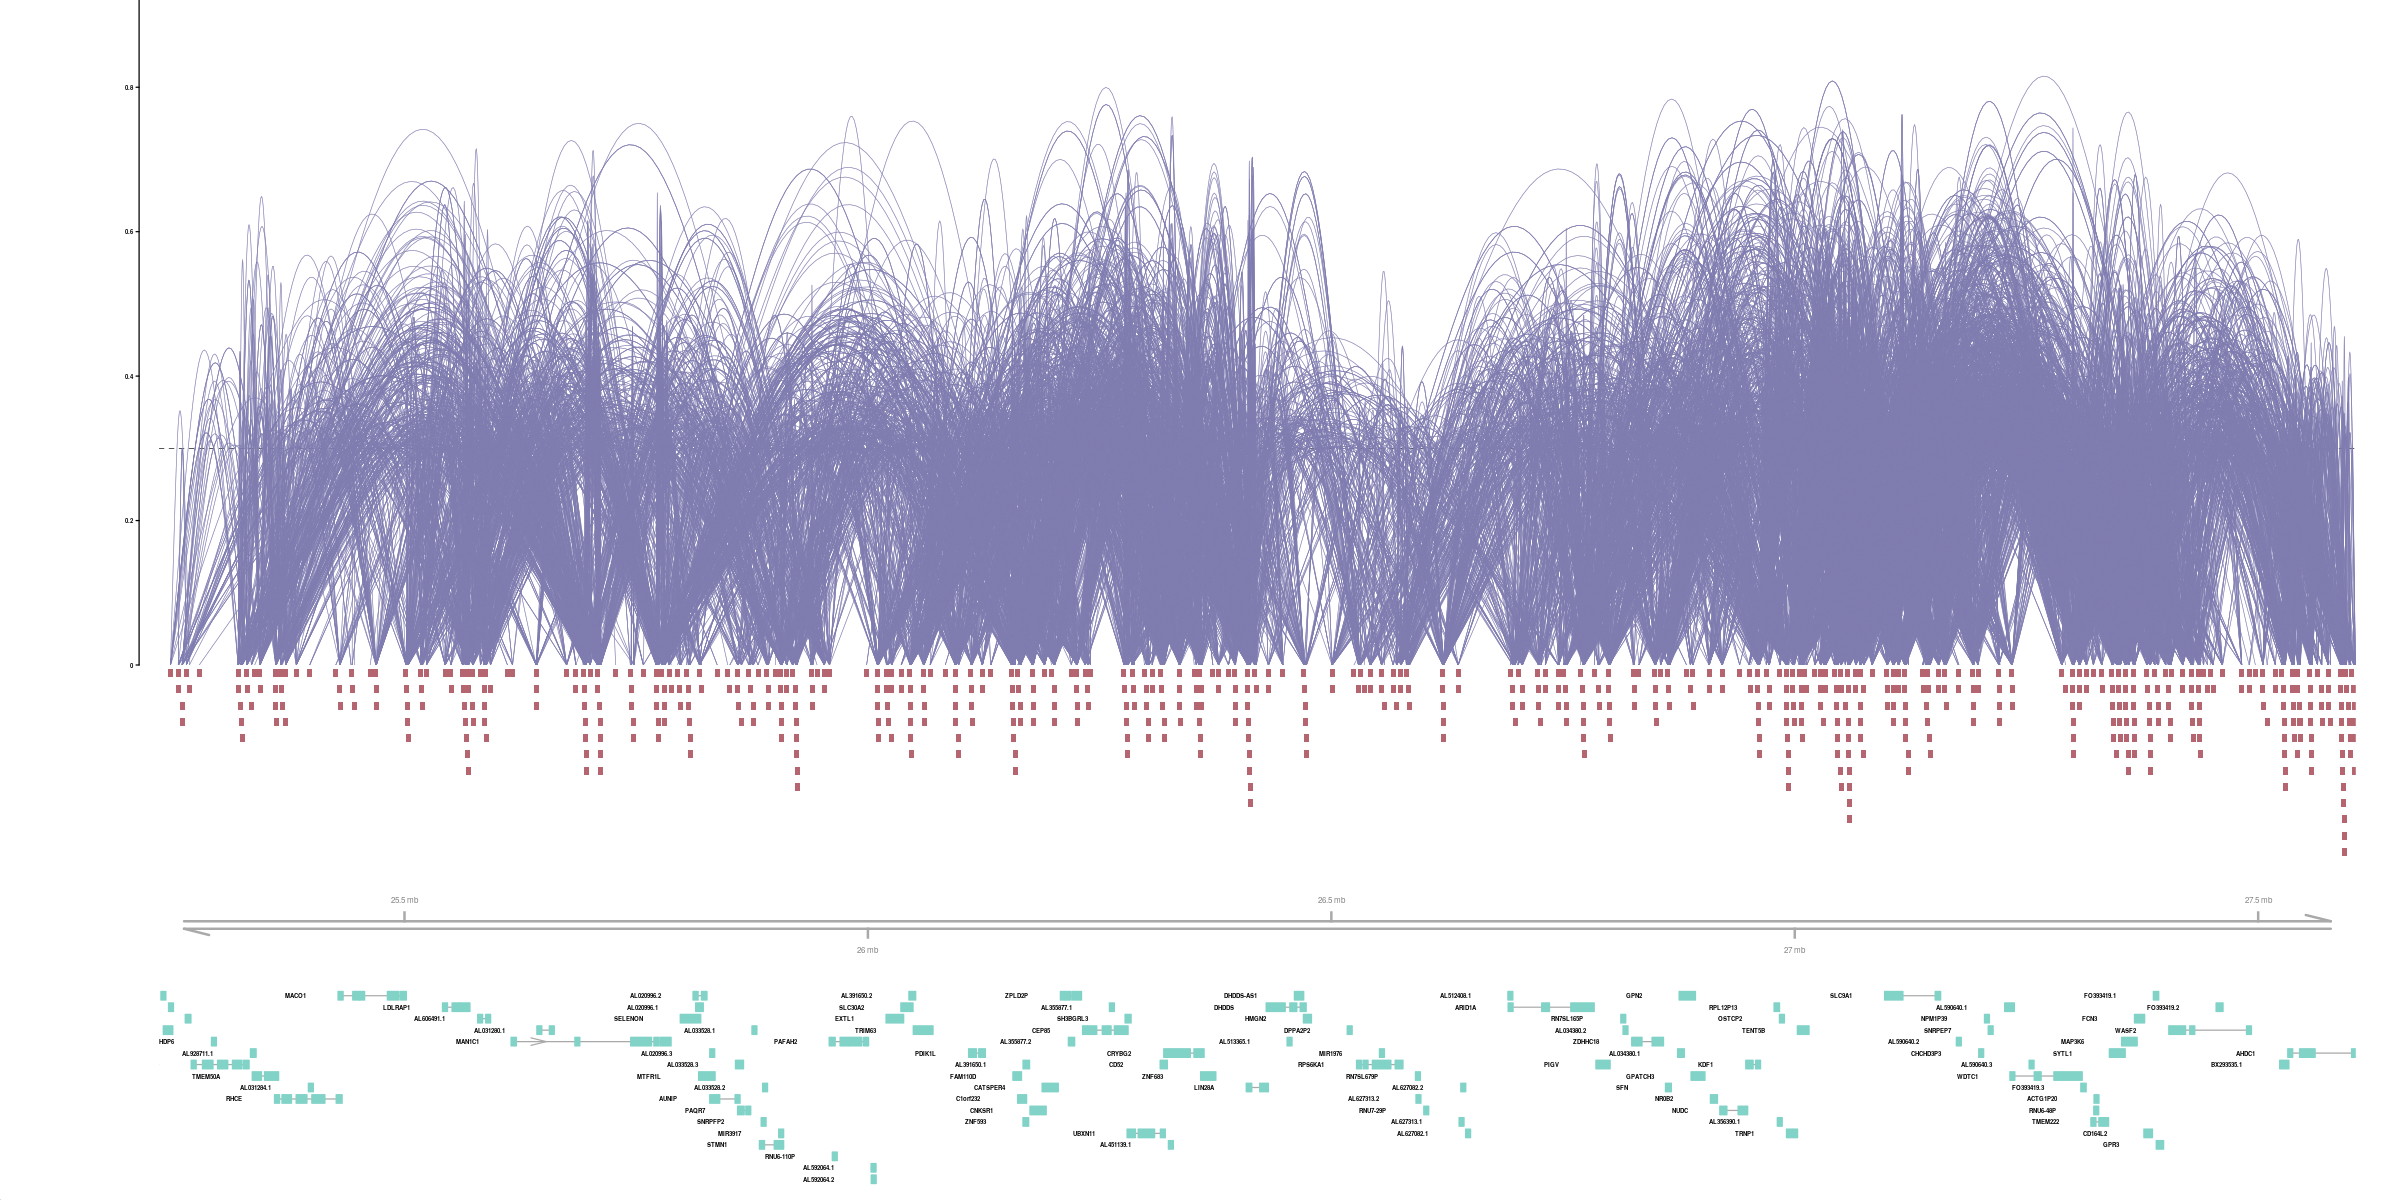

In [57]:
options(repr.plot.width = 20, repr.plot.height = 10)

plot_connections(high_conns[high_conns$distance>10000,], "chr1", 25235185, 27605310,
                 gene_model = gene_anno, 
                 coaccess_cutoff = .3, 
                 connection_width = .5, 
                 collapseTranscripts = "longest" )

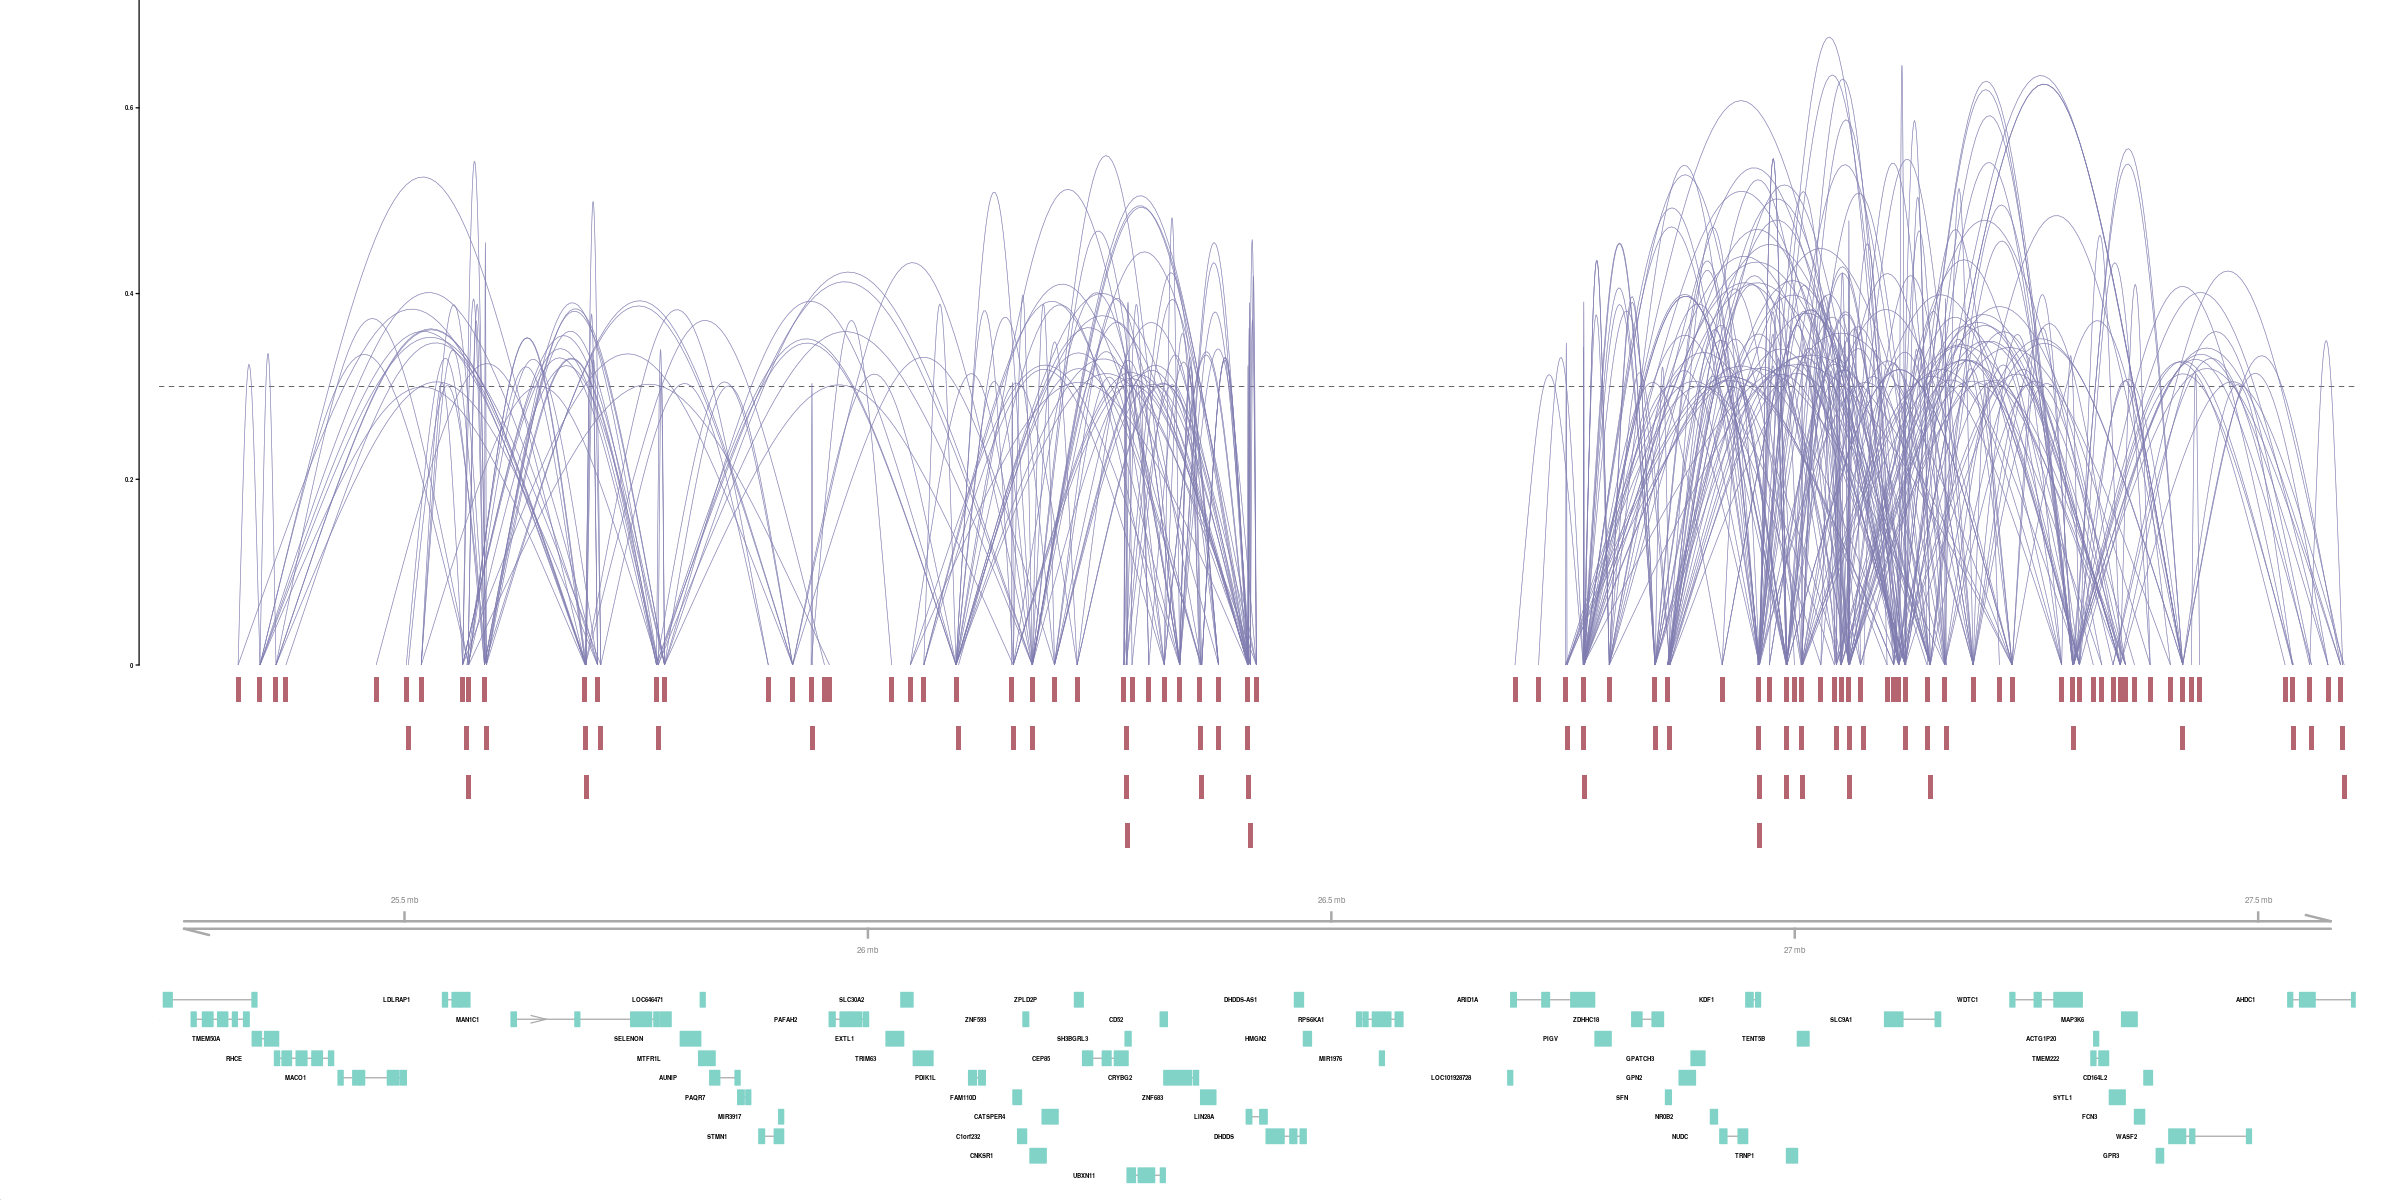

In [269]:
# old run (20200417_default_20200220_n74838)
options(repr.plot.width = 20, repr.plot.height = 10)

plot_connections(high_conns[high_conns$distance>1000,], "chr1", 25235185, 27605310,
                 gene_model = gene_anno, 
                 coaccess_cutoff = .3, 
                 connection_width = .5, 
                 collapseTranscripts = "longest" )

## Cis-coaccessibility Networks (CCANs)

In [78]:
CCAN_assigns <- generate_ccans(conns)

[1] "Coaccessibility cutoff used: 0.25"


In [79]:
dim(CCAN_assigns)

[1] 74414     2

In [80]:
quantile(table(CCAN_assigns$CCAN), c(0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1))

  0%  25%  50%  75%  90%  95%  99% 100% 
   3    4    9   22   46   68  128  283 

In [361]:
quantile(table(CCAN_assigns$CCAN), c(0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1))

    0%    25%    50%    75%    90%    95%    99%   100% 
  3.00   3.00   3.00   6.00  23.00  43.00 105.62 377.00 

In [81]:
gz = gzfile("./out/20200526_default_20200520_n68916_overlap_merged_500bp/ccans.thresh0.25.tsv.gz")
write.table(CCAN_assigns, file=gz, col.names=F, row.names=F, sep='\t', quote=F)

## Gene Scores

In [388]:
gene_anno <- rtracklayer::readGFF("/users/surag/kundajelab/scATAC-reprog/resources/refGene/hg38.refGene.gtf.gz")
gene_anno = subset(gene_anno, type=="transcript")

# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqid
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_id
gene_anno$symbol <- gene_anno$gene_name

In [389]:
pos <- subset(gene_anno, strand == "+")
pos <- pos[order(pos$start),] 
# remove all but the first exons per transcript
pos <- pos[!duplicated(pos$transcript),] 
# make a 1 base pair marker of the TSS
pos$end <- pos$start + 1 

neg <- subset(gene_anno, strand == "-")
neg <- neg[order(neg$start, decreasing = TRUE),] 
# remove all but the first exons per transcript
neg <- neg[!duplicated(neg$transcript),] 
neg$start <- neg$end - 1

gene_annotation_sub <- rbind(pos, neg)

In [391]:
# keep multiple TSSes
gene_annotation_sub$gene_transcript = paste(gene_annotation_sub$symbol, 
                                            gene_annotation_sub$transcript_id,
                                            sep=':')

In [392]:
gene_annotation_sub <- gene_annotation_sub[,c("chromosome", "start", "end", "gene_transcript")]

# Rename the gene symbol column to "gene"
names(gene_annotation_sub)[4] <- "gene"

In [393]:
# remove alt chromosomes
gene_annotation_sub = gene_annotation_sub[!grepl("_", gene_annotation_sub$chromosome), ]

In [394]:
dim(gene_annotation_sub)
head(gene_annotation_sub)

[1] 74538     4

chromosome start end   gene                  
142128  chr10      11207 11208 LINC02564:NR_149138   
518548  chr16      11555 11556 DDX11L10:NR_045117    
662266  chr18      11560 11561 LINC02564:NR_149138_2 
142132  chr10      11721 11722 LOC102723376:NR_110795
142136  chr10      11721 11722 LINC02564:NR_149137   
1003412 chr3       11751 11752 LINC01986:NR_110824

In [395]:
input_cds <- annotate_cds_by_site(input_cds, gene_annotation_sub)

In [406]:
sum(!is.na(fData(input_cds)$gene))

[1] 18678

In [447]:
# generate unnormalized gene activity matrix
unnorm_ga <- build_gene_activity_matrix(input_cds, conns,
                                       coaccess_cutoff=0.1)

In [448]:
# remove any rows/columns with all zeroes
unnorm_ga <- unnorm_ga[!Matrix::rowSums(unnorm_ga) == 0, 
                       !Matrix::colSums(unnorm_ga) == 0]

In [470]:
head(pData(input_cds))

DataFrame with 6 rows and 8 columns
                      sample           umap.1            umap.2   cluster
                    <factor>        <numeric>         <numeric> <integer>
D0_AAACAACGACGATTAC       D0 6.54568615124207 -7.70175130000044         2
D0_AAACAACGACTCACGG       D0 5.18066310038458 -7.63329829280168         2
D0_AAACAACGAGCGCACT       D0 6.08064808718972 -8.11470528673739         2
D0_AAACAACGATGGAACG       D0 3.58447389033384 -7.27675376068122         1
D0_AAACACGCTACGCCAC       D0 5.29955091176473  -8.1337820992278         2
D0_AAACACGCTAGACTTC       D0 6.74474712641921   -7.763450197359         2
                             barcode               cells       Size_Factor
                              <list>         <character>         <numeric>
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0_AAACAACGACGATTAC  3.66828417172131
D0_AAACAACGACTCACGG AAACAACGACTCACGG D0_AAACAACGACTCACGG 0.451658471078955
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0_AAACAACGAGCGCACT  1.966967401891

In [449]:
# make a list of num_genes_expressed
num_genes <- pData(input_cds)$num_genes_expressed
names(num_genes) <- row.names(pData(input_cds))

In [450]:
# normalize
cicero_gene_activities <- normalize_gene_activities(unnorm_ga, num_genes)

In [451]:
dim(cicero_gene_activities)

[1] 18678 74838

In [468]:
rownames(cicero_gene_activities)[grep("OASL", rownames(cicero_gene_activities))]

[1] "OASL:NM_198213"

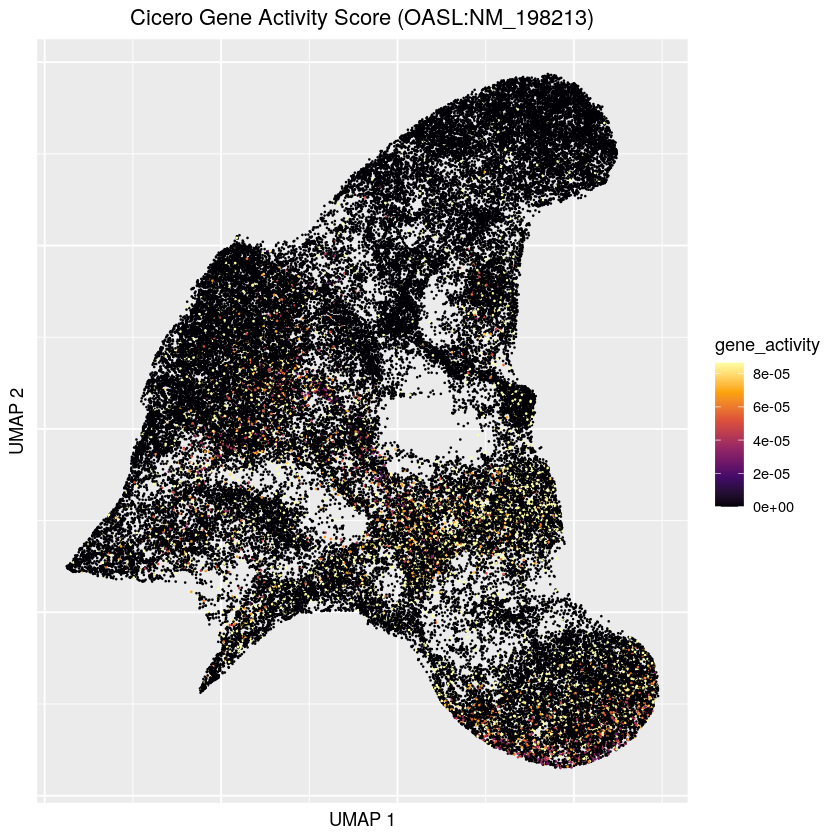

In [469]:
options(repr.plot.width = 7, repr.plot.height = 7)

GENE = 'OASL:NM_198213'

df = data.frame(metaData, gene_activity=cicero_gene_activities[GENE,])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=gene_activity)) +
ggtitle(sprintf("Cicero Gene Activity Score (%s)",  
               GENE)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(cicero_gene_activities[GENE,], 0.1), 
                               quantile(cicero_gene_activities[GENE,], 0.95)), 
                      oob=squish, option = "B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text = element_blank())